In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [2]:
input_file="https://raw.githubusercontent.com/AADRIANV/CST-383-F24-Project-2/refs/heads/main/NIJ_s_Recidivism_Challenge_Training_Dataset_20241205.csv"
df=pd.read_csv(input_file)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 53 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 18028 non-null  int64  
 1   Gender                                             18028 non-null  object 
 2   Race                                               18028 non-null  object 
 3   Age_at_Release                                     18028 non-null  object 
 4   Residence_PUMA                                     18028 non-null  int64  
 5   Gang_Affiliated                                    15811 non-null  object 
 6   Supervision_Risk_Score_First                       17698 non-null  float64
 7   Supervision_Level_First                            16816 non-null  object 
 8   Education_Level                                    18028 non-null  object 
 9   Depend

In [4]:
df=df.drop(["Residence_PUMA","Condition_MH_SA", "Condition_Cog_Ed", "Condition_Other", "DrugTests_THC_Positive", "DrugTests_Cocaine_Positive", "DrugTests_Meth_Positive", "DrugTests_Other_Positive", "Percent_Days_Employed"], axis =1 )

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 44 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 18028 non-null  int64  
 1   Gender                                             18028 non-null  object 
 2   Race                                               18028 non-null  object 
 3   Age_at_Release                                     18028 non-null  object 
 4   Gang_Affiliated                                    15811 non-null  object 
 5   Supervision_Risk_Score_First                       17698 non-null  float64
 6   Supervision_Level_First                            16816 non-null  object 
 7   Education_Level                                    18028 non-null  object 
 8   Dependents                                         18028 non-null  object 
 9   Prison

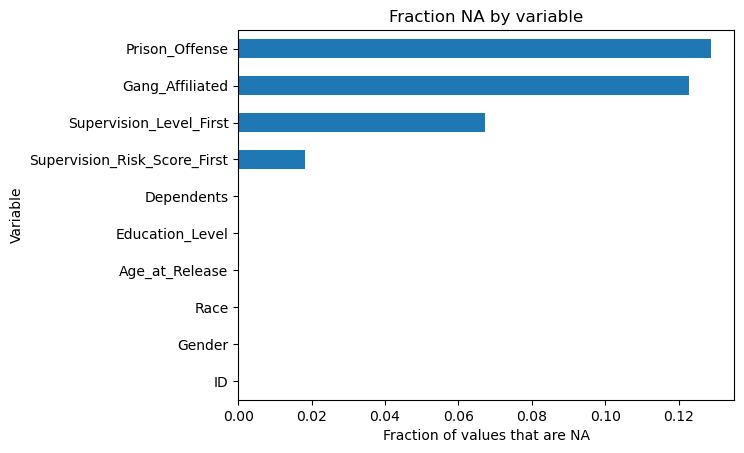

In [6]:
df.isna().mean().head(10).sort_values().plot.barh()
plt.title('Fraction NA by variable')
plt.xlabel('Fraction of values that are NA')
plt.ylabel('Variable');

In [7]:
df.apply([pd.Series.nunique, pd.Series.unique]).transpose()

,nunique,unique
ID,18028,"[1, 2, 3, 4, 5, 7, 9, 10, 11, 13, 14, 17, 18, ..."
Gender,2,"[M, F]"
Race,2,"[BLACK, WHITE]"
Age_at_Release,7,"[43-47, 33-37, 48 or older, 38-42, 18-22, 23-2..."
Gang_Affiliated,2,"[False, nan, True]"
Supervision_Risk_Score_First,10,"[3.0, 6.0, 7.0, 4.0, 2.0, 5.0, 1.0, 10.0, 9.0,..."
Supervision_Level_First,3,"[Standard, Specialized, High, nan]"
Education_Level,3,"[At least some college, Less than HS diploma, ..."
Dependents,4,"[3 or more, 1, 2, 0]"
Prison_Offense,5,"[Drug, Violent/Non-Sex, Property, nan, Other, ..."


In [8]:
print(df['Prison_Offense'])

0                   Drug
1        Violent/Non-Sex
2                   Drug
3               Property
4        Violent/Non-Sex
              ...       
18023                NaN
18024                NaN
18025                NaN
18026                NaN
18027                NaN
Name: Prison_Offense, Length: 18028, dtype: object


We will now fill the prison offense column na values with a new classification that will be unknown.  We will do the same with the gang affiliatted column since the options are clear cut with True/False.  For the Supervision_Level_First column we will replace na values with 'Standard'.  And Finally for the Supervision_Risck_Score_First we will replace na values with the median score.  

In [9]:
df['Prison_Offense'] = df['Prison_Offense'].fillna('Unknown')
df['Gang_Affiliated'] = df['Gang_Affiliated'].fillna('Unknown')
df['Supervision_Level_First'] = df['Supervision_Level_First'].fillna('Standard')
df['Supervision_Risk_Score_First'] = df['Supervision_Risk_Score_First'].fillna(df['Supervision_Risk_Score_First'].median())
df['Avg_Days_per_DrugTest'] = df['Avg_Days_per_DrugTest'].fillna(df['Avg_Days_per_DrugTest'].median())
df['Jobs_Per_Year'] = df['Jobs_Per_Year'].fillna(df['Jobs_Per_Year'].median())

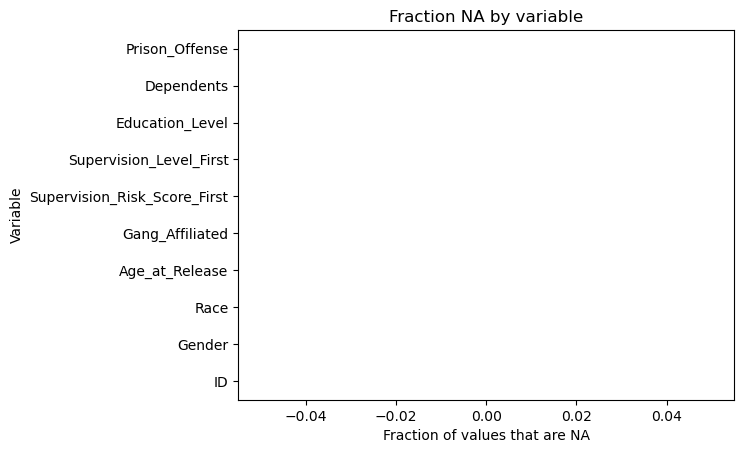

In [10]:
df.isna().mean().head(10).sort_values().plot.barh()
plt.title('Fraction NA by variable')
plt.xlabel('Fraction of values that are NA')
plt.ylabel('Variable');

Now we can see that all of our na values are taken care of.  Now we have to do encoding for the catagorical varibles since logistic regression has to use numerical data.

In [11]:
catagorical_data = ['Gender', 'Race', 'Supervision_Level_First', 'Education_Level', 'Prison_Offense', 'Gang_Affiliated', 'Age_at_Release', 'Prison_Years']
df = pd.get_dummies(df, columns=catagorical_data, drop_first=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 58 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 18028 non-null  int64  
 1   Supervision_Risk_Score_First                       18028 non-null  float64
 2   Dependents                                         18028 non-null  object 
 3   Prior_Arrest_Episodes_Felony                       18028 non-null  object 
 4   Prior_Arrest_Episodes_Misd                         18028 non-null  object 
 5   Prior_Arrest_Episodes_Violent                      18028 non-null  object 
 6   Prior_Arrest_Episodes_Property                     18028 non-null  object 
 7   Prior_Arrest_Episodes_Drug                         18028 non-null  object 
 8   Prior_Arrest_Episodes_PPViolationCharges           18028 non-null  object 
 9   Prior_

We now have to scale some of the numerical data.

In [13]:
numeric_data = ['Supervision_Risk_Score_First', 'Avg_Days_per_DrugTest', 'Jobs_Per_Year']
scale = StandardScaler()
df[numeric_data] = scale.fit_transform(df[numeric_data])

Lastly we have to encode all columns with catagories like "4 or more".  We will set a cap on these columns and convert "4 or more" entries to the number 4.

In [14]:
cols = ['Prior_Conviction_Episodes_Drug']
mapping = {'2 or more': 2}
df[cols] = df[cols].replace(mapping)
cols = ['Dependents', 'Prior_Arrest_Episodes_Violent', 'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Prop', 'Program_UnexcusedAbsences','Residence_Changes']
mapping = {'3 or more': 3}
df[cols] = df[cols].replace(mapping)
cols = ['Prior_Conviction_Episodes_Misd', 'Delinquency_Reports']
mapping = {'4 or more': 4}
df[cols] = df[cols].replace(mapping)
cols = ['Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges']
mapping = {'5 or more': 5}
df[cols] = df[cols].replace(mapping)
cols = ['Prior_Arrest_Episodes_Misd']
mapping = {'6 or more': 6}
df[cols] = df[cols].replace(mapping)
cols = ['Prior_Arrest_Episodes_Felony', 'Program_Attendances']
mapping = {'10 or more': 10}
df[cols] = df[cols].replace(mapping)

Now we can preform a test train split and start to make predictions.

In [15]:
df.isna().sum()

ID                                                   0
Supervision_Risk_Score_First                         0
Dependents                                           0
Prior_Arrest_Episodes_Felony                         0
Prior_Arrest_Episodes_Misd                           0
Prior_Arrest_Episodes_Violent                        0
Prior_Arrest_Episodes_Property                       0
Prior_Arrest_Episodes_Drug                           0
Prior_Arrest_Episodes_PPViolationCharges             0
Prior_Arrest_Episodes_DVCharges                      0
Prior_Arrest_Episodes_GunCharges                     0
Prior_Conviction_Episodes_Felony                     0
Prior_Conviction_Episodes_Misd                       0
Prior_Conviction_Episodes_Viol                       0
Prior_Conviction_Episodes_Prop                       0
Prior_Conviction_Episodes_Drug                       0
Prior_Conviction_Episodes_PPViolationCharges         0
Prior_Conviction_Episodes_DomesticViolenceCharges    0
Prior_Conv

In [16]:
df.apply([pd.Series.nunique, pd.Series.unique]).transpose()

,nunique,unique
ID,18028,"[1, 2, 3, 4, 5, 7, 9, 10, 11, 13, 14, 17, 18, ..."
Supervision_Risk_Score_First,10,"[-1.297654171637761, -0.02692579541366771, 0.3..."
Dependents,4,"[3, 1, 2, 0]"
Prior_Arrest_Episodes_Felony,11,"[6, 7, 8, 4, 10, 3, 9, 5, 2, 1, 0]"
Prior_Arrest_Episodes_Misd,7,"[6, 4, 3, 5, 2, 0, 1]"
Prior_Arrest_Episodes_Violent,4,"[1, 3, 0, 2]"
Prior_Arrest_Episodes_Property,6,"[3, 0, 2, 5, 1, 4]"
Prior_Arrest_Episodes_Drug,6,"[3, 2, 1, 5, 0, 4]"
Prior_Arrest_Episodes_PPViolationCharges,6,"[4, 5, 3, 1, 2, 0]"
Prior_Arrest_Episodes_DVCharges,2,"[False, True]"


In [17]:
X = df.drop(columns=['ID', 'Recidivism_Within_3years', 'Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'])
y = df['Recidivism_Within_3years']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(y.value_counts())

Recidivism_Within_3years
True     10421
False     7607
Name: count, dtype: int64


In [18]:
regr = LogisticRegression(max_iter=1000, C=10)
regr.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000)

<Axes: xlabel='Feature'>

<Figure size 1200x1600 with 0 Axes>

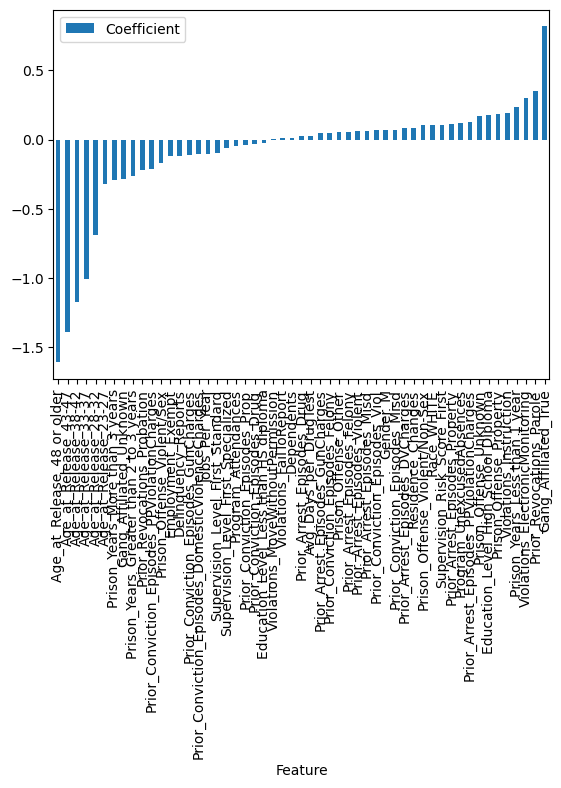

In [19]:
coefficients = regr.coef_[0]
feature_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})
plt.figure(figsize=(12, 16))
feature_coefficients.sort_values(by='Coefficient', ascending=True).plot.bar(x='Feature', y='Coefficient')

              precision    recall  f1-score   support

       False       0.67      0.52      0.59      2322
        True       0.69      0.81      0.75      3087

    accuracy                           0.69      5409
   macro avg       0.68      0.67      0.67      5409
weighted avg       0.68      0.69      0.68      5409

ROC-AUC Score: 0.7424979917728955


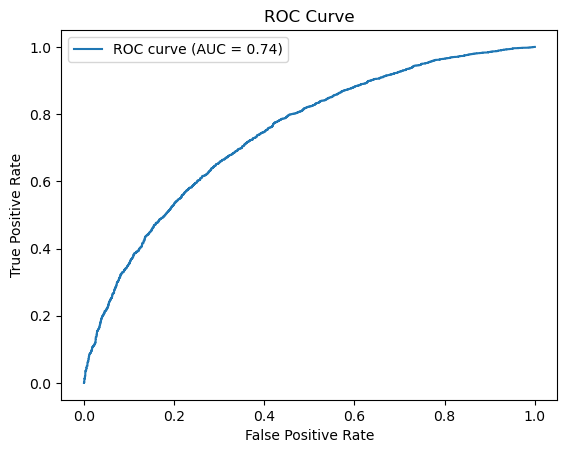

In [20]:
y_pred = regr.predict(X_test)
y_proba = regr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [21]:
X = df.drop(columns=['ID', 'Recidivism_Within_3years'])
y = df['Recidivism_Within_3years']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(y.value_counts())

Recidivism_Within_3years
True     10421
False     7607
Name: count, dtype: int64


In [22]:
regr = LogisticRegression(max_iter=1000, C=10)
regr.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2322
        True       1.00      1.00      1.00      3087

    accuracy                           1.00      5409
   macro avg       1.00      1.00      1.00      5409
weighted avg       1.00      1.00      1.00      5409

ROC-AUC Score: 1.0


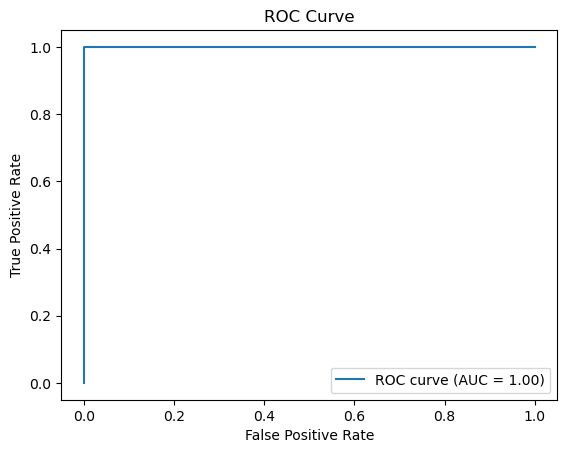

In [23]:
y_pred = regr.predict(X_test)
y_proba = regr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [24]:
# X = df.drop(columns=['ID', 'Recidivism_Within_3years', 'Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'])
# y = df['Recidivism_Arrest_Year2']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# print(y.value_counts())

In [25]:
# regr = LogisticRegression(max_iter=1000, C=10)
# regr.fit(X_train, y_train)

In [26]:
# y_pred = regr.predict(X_test)
# y_proba = regr.predict_proba(X_test)[:, 1]

# print(classification_report(y_test, y_pred))

# roc_auc = roc_auc_score(y_test, y_proba)
# print("ROC-AUC Score:", roc_auc)

# fpr, tpr, _ = roc_curve(y_test, y_proba)
# plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

In [27]:
# X = df.drop(columns=['ID', 'Recidivism_Within_3years', 'Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'])
# y = df['Recidivism_Arrest_Year3']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# print(y.value_counts())

In [28]:
# regr = LogisticRegression(max_iter=1000, C=10)
# regr.fit(X_train, y_train)

In [29]:
# y_pred = regr.predict(X_test)
# y_proba = regr.predict_proba(X_test)[:, 1]

# print(classification_report(y_test, y_pred))

# roc_auc = roc_auc_score(y_test, y_proba)
# print("ROC-AUC Score:", roc_auc)

# fpr, tpr, _ = roc_curve(y_test, y_proba)
# plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

In [30]:

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 0.1}
